<a href="https://colab.research.google.com/github/moliva123/medm_bee/blob/master/MEDM_bee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [3]:
!git clone https://github.com/moliva123/medm_bee.git
%cd medm_bee/

import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from matplotlib import rcParams

import itertools
import operator
import scipy.stats as ss

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,balanced_accuracy_score


from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#functions used
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def specificity(clf,cm):
  #cm is the confusion matrix
  FP = cm.sum(axis=0) - np.diag(cm)  #vector with nr of false positives of each label
  FN = cm.sum(axis=1) - np.diag(cm) #vector with nr of false negatives of each label
  TP = np.diag(cm) #vector with nr of true positives of each label
  TN = cm.sum() - (FP + FN + TP) #vector with nr of true negatives of each label

  FP = FP.astype(float)
  TN = TN.astype(float)
  
  sp = TN/(TN+FP) #vector with specificity of each label
  sp_mean = np.mean(sp)
  labels=clf.classes_
  res = "\n".join("{:>25} "     " {}".format(x, y) for x, y in zip(labels, sp))
  print(res)
  print('\nmacro avg:', sp_mean)

def print_score(classifier,X_test,y_test):
  print("Test results:\n")
  print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_test,classifier.predict(X_test))))
  print('Balanced Accuracy Score: {0:.4f}\n'.format(balanced_accuracy_score(y_test,classifier.predict(X_test))))
  print('Classification Report:\n{}\n'.format(classification_report(y_test,classifier.predict(X_test))))
  print('Confusion Matrix:\n{}\n'.format(confusion_matrix(y_test,classifier.predict(X_test))))
  print("Specificity:\n") 
  print(specificity(classifier,confusion_matrix(y_test,classifier.predict(X_test))))

def calculate_auc(classifier, X_test, y_test):
  y_pred = classifier.predict(X_test)
  y_prob = classifier.predict_proba(X_test)

  macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                    average="macro")
  weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                      average="weighted")
  macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                    average="macro")
  weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                      average="weighted")
  print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
        "(weighted by prevalence)"
        .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
  print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
        "(weighted by prevalence)"
        .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Pre Processing

In [4]:
data = pd.read_csv("bee_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file             5172 non-null   object
 1   date             5172 non-null   object
 2   time             5172 non-null   object
 3   location         5172 non-null   object
 4   zip code         5172 non-null   int64 
 5   subspecies       5172 non-null   object
 6   health           5172 non-null   object
 7   pollen_carrying  5172 non-null   bool  
 8   caste            5172 non-null   object
dtypes: bool(1), int64(1), object(7)
memory usage: 328.4+ KB


In [5]:
data.subspecies.describe()

count                  5172
unique                    7
top       Italian honey bee
freq                   3008
Name: subspecies, dtype: object

In [6]:
data.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


## Plots

In [0]:
#remove all rows where subespecie is -1
data = data[data['subspecies'] != '-1']
#delete column caste because all values are "worker"
del data['caste']

([0, 1, 2, 3, 4, 5], <a list of 6 Text major ticklabel objects>)

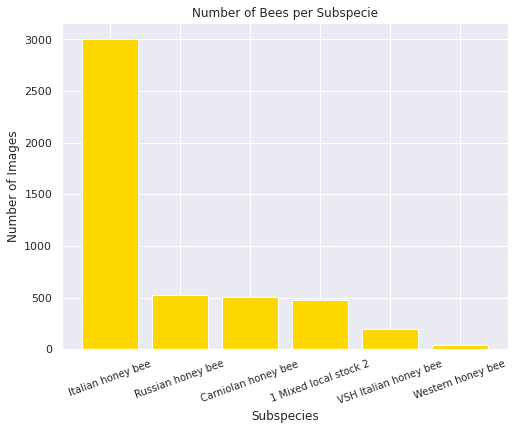

In [8]:
rcParams['figure.figsize'] = 8,6
plt.bar(data['subspecies'].value_counts().index,data['subspecies'].value_counts(),color='gold')
plt.xlabel('Subspecies')
plt.ylabel('Number of Images')
plt.title('Number of Bees per Subspecie')
plt.xticks(rotation=20,fontsize=10)

In [9]:
data['subspecies'].value_counts()

Italian honey bee        3008
Russian honey bee         527
Carniolan honey bee       501
1 Mixed local stock 2     472
VSH Italian honey bee     199
Western honey bee          37
Name: subspecies, dtype: int64

In [0]:
#join Athens Georgia USA with Athens GA USA
data = data.replace({'location':'Athens, Georgia, USA'}, 'Athens, GA, USA')

([0, 1, 2, 3, 4, 5], <a list of 6 Text major ticklabel objects>)

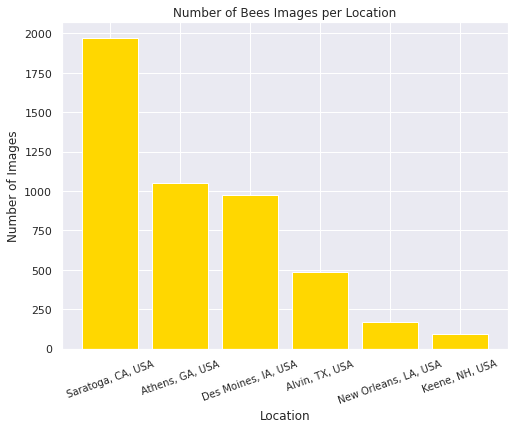

In [11]:
rcParams['figure.figsize'] = 8,6
plt.bar(data['location'].value_counts().index,data['location'].value_counts(),color='gold')
plt.xlabel('Location')
plt.ylabel('Number of Images')
plt.title('Number of Bees Images per Location')
plt.xticks(rotation=20,fontsize=10)


In [12]:
data['location'].value_counts()

Saratoga, CA, USA       1972
Athens, GA, USA         1051
Des Moines, IA, USA      973
Alvin, TX, USA           486
New Orleans, LA, USA     170
Keene, NH, USA            92
Name: location, dtype: int64

([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

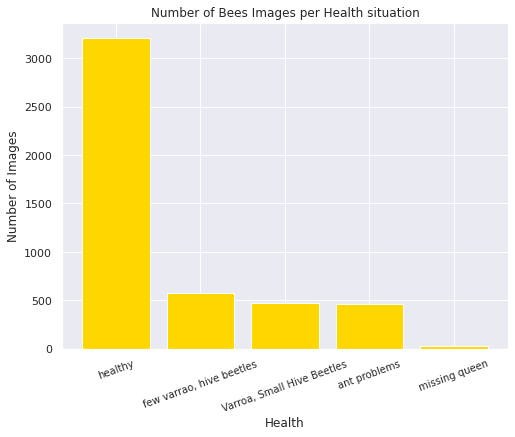

In [13]:
rcParams['figure.figsize'] = 8,6
plt.bar(data['health'].value_counts().index,data['health'].value_counts(),color='gold')
plt.xlabel('Health')
plt.ylabel('Number of Images')
plt.title('Number of Bees Images per Health situation')
plt.xticks(rotation=20, fontsize=10)


In [14]:
#count the number of bees per health per location and per subspecies
data.groupby(['health', 'location','subspecies']).size().to_frame('Count').reset_index()

,health,location,subspecies,Count
0,"Varroa, Small Hive Beetles","Athens, GA, USA",1 Mixed local stock 2,472
1,ant problems,"Alvin, TX, USA",Italian honey bee,457
2,"few varrao, hive beetles","Athens, GA, USA",Italian honey bee,579
3,healthy,"Des Moines, IA, USA",Carniolan honey bee,501
4,healthy,"Des Moines, IA, USA",Russian honey bee,435
5,healthy,"Des Moines, IA, USA",Western honey bee,37
6,healthy,"Keene, NH, USA",Russian honey bee,92
7,healthy,"New Orleans, LA, USA",VSH Italian honey bee,170
8,healthy,"Saratoga, CA, USA",Italian honey bee,1972
9,missing queen,"Alvin, TX, USA",VSH Italian honey bee,29


In [15]:
#count the number of bees who carry and dont carry pollen (highly unballanced)
data['pollen_carrying'].value_counts()

False    4738
True        6
Name: pollen_carrying, dtype: int64

In [16]:

#count the number of bees who carry pollen per subspecies
data.groupby(['pollen_carrying', 'subspecies']).size().to_frame('Count').reset_index()

,pollen_carrying,subspecies,Count
0,False,1 Mixed local stock 2,472
1,False,Carniolan honey bee,501
2,False,Italian honey bee,3002
3,False,Russian honey bee,527
4,False,VSH Italian honey bee,199
5,False,Western honey bee,37
6,True,Italian honey bee,6


In [0]:
data['date_time'] = pd.to_datetime(data['date'] + ' ' + data['time'])
data['month'] = data['date_time'].dt.month
data['hour']= data['date_time'].dt.hour

In [18]:
data['month'].value_counts()


8    4011
7     733
Name: month, dtype: int64

In [19]:
# Add a new column named 'Day Time' 
timeofday=pd.cut(data['hour'],bins=[0,12,17,22],labels=['Morning','Afternoon','Evening'])
data.insert(11,'Day Time',timeofday)
data['Day Time'].value_counts()

Afternoon    2526
Morning      1799
Evening       419
Name: Day Time, dtype: int64

In [0]:
del data['date']
del data['time']
del data['hour']
del data['date_time']
del data['file']

# Add a new column named 'address' ('location' and 'zip code')
data['address'] = data['location'].str.cat(data['zip code'].astype(str), sep =" ") 
del data['location']
del data['zip code']

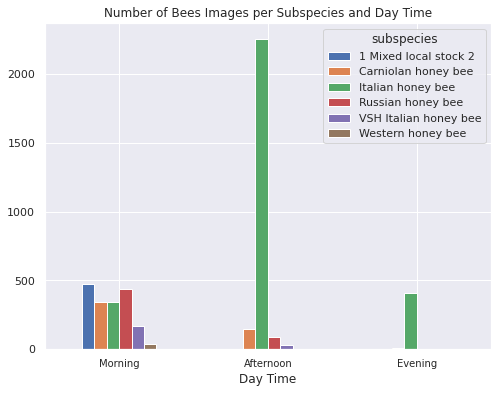

In [21]:
data1=data.groupby(['Day Time', 'subspecies']).size().to_frame('Count').reset_index()
data1.pivot("Day Time", "subspecies", "Count").plot(kind='bar')
plt.title('Number of Bees Images per Subspecies and Day Time')
plt.xticks(rotation=0, fontsize=10)
plt.show()

## Correlation

Text(0.5, 1.0, 'Cramer V Correlation between Variables')

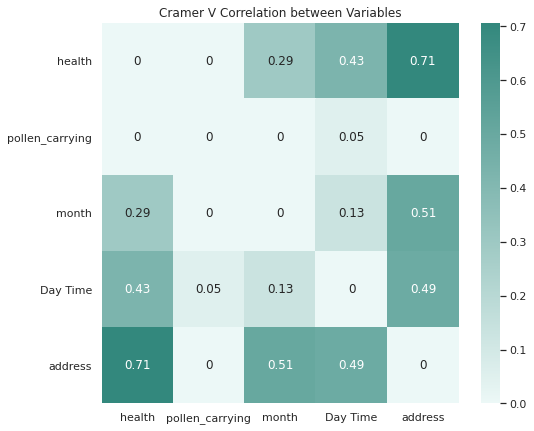

In [23]:
cols = data.columns[1:6]
corrM = np.zeros((len(cols),len(cols)))
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.get_loc(col1), cols.get_loc(col2)
    corrM[idx1, idx2] = cramers_v(data[col1], data[col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(8, 7))
ax = sns.heatmap(corr,
                 cmap=sns.light_palette("#33887D",as_cmap=True),
                 annot=True,
                 ax=ax);
                 
ax.set_title("Cramer V Correlation between Variables")
                 #annot=True shows the numerical values

## Encoding

In [24]:
#Convert categorical variables into dummy variables
data=pd.get_dummies(data, columns=['address','health','Day Time','month'])

#Convert boolean values (pollen_carrying) into 0 or 1
data['pollen_carrying']=data['pollen_carrying'].astype(int)


data.head()

,subspecies,pollen_carrying,"address_Alvin, TX, USA 77511","address_Athens, GA, USA 30607","address_Des Moines, IA, USA 50315","address_Keene, NH, USA 3431","address_New Orleans, LA, USA 70115","address_Saratoga, CA, USA 95070","health_Varroa, Small Hive Beetles",health_ant problems,"health_few varrao, hive beetles",health_healthy,health_missing queen,Day Time_Morning,Day Time_Afternoon,Day Time_Evening,month_7,month_8
74,Italian honey bee,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
75,Italian honey bee,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
76,Italian honey bee,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
77,Italian honey bee,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
78,Italian honey bee,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1


# Classification

In [0]:
data = pd.read_csv('bee_data_final.csv',index_col=0)

#Split into training and test sets
y = data['subspecies']
X = data.drop(['subspecies'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=47)

In [55]:
y_train.value_counts()

Italian honey bee        2108
Russian honey bee         374
Carniolan honey bee       340
1 Mixed local stock 2     328
VSH Italian honey bee     144
Western honey bee          26
Name: subspecies, dtype: int64

In [48]:
y_test.value_counts()

Italian honey bee        900
Carniolan honey bee      161
Russian honey bee        153
1 Mixed local stock 2    144
VSH Italian honey bee     55
Western honey bee         11
Name: subspecies, dtype: int64

## KNN

In [0]:
from scipy.spatial.distance import jaccard
from scipy.spatial.distance import hamming

Text(0.5, 1.0, 'K Neighbors Classifier scores for different K values')

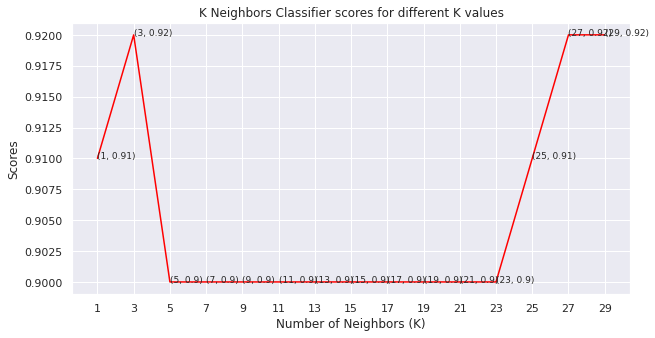

In [49]:
#KNN Classifier scores using all variables

knn_scores = []
K_list=range(1,30,2)
for k in K_list:
    knn_clf = KNeighborsClassifier(n_neighbors = k, metric='jaccard')
    knn_scores.append(round(np.mean(cross_val_score(knn_clf,X_train,y_train,scoring='accuracy',cv=10)),2))

plt.figure(figsize=(10,5))
plt.plot([k for k in K_list], knn_scores, color = 'red')
for i in range(len(K_list)):
    plt.text(K_list[i], knn_scores[i], (K_list[i], knn_scores[i]),fontsize=9)
plt.xticks([i for i in K_list])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')

In [75]:
#Best parameters
knn_clf = KNeighborsClassifier(n_neighbors=27, metric='jaccard')
knn_clf.fit(X_train, y_train)

#Test Results 
print_score(knn_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(knn_clf, X_test, y_test)

Test results:

Accuracy Score: 0.9122

Balanced Accuracy Score: 0.7153

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       1.00      1.00      1.00       900
    Russian honey bee       0.55      1.00      0.71       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.00      0.00      0.00        11

             accuracy                           0.91      1424
            macro avg       0.76      0.72      0.69      1424
         weighted avg       0.94      0.91      0.90      1424




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0 114   0   0]
 [  0   0 900   0   0   0]
 [  0   0   0 153   0   0]
 [  0   0   0   0  55   0]
 [  0   0   0  11   0   0]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Italian honey bee  1.0
        Russian honey bee  0.9016522423288749
    VSH Italian honey bee  1.0
        Western honey bee  1.0

macro avg: 0.9836087070548124
None


One-vs-One ROC AUC scores:
0.928021 (macro),
0.968396 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.972059 (macro),
0.990375 (weighted by prevalence)


## SVM

In [0]:
parameters = {'C': [0.001,0.01,0.1,1,10,100], 'kernel' : ['poly','rbf','sigmoid','linear'], 'gamma':[0.001, 0.01,0.1]}

svm_clf = svm.SVC()
svm_cv = GridSearchCV(estimator=svm_clf, param_grid=parameters, scoring='accuracy', cv=5, n_jobs=-1)
svm_cv.fit(X_train, y_train)
print('Best parameters set found:',svm_cv.best_params_)
print('Score with best parameters:',svm_cv.best_score_)

Best parameters set found: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Score with best parameters: 0.9240963855421687


In [0]:
#Best parameters
svm_clf = svm.SVC(C=0.1, kernel='linear', probability=True)
svm_clf.fit(X_train, y_train)

#Test Results 
print_score(svm_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(svm_clf, X_test, y_test)

Test results:

Accuracy Score: 0.9122

Balanced Accuracy Score: 0.7153

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       1.00      1.00      1.00       900
    Russian honey bee       0.55      1.00      0.71       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.00      0.00      0.00        11

             accuracy                           0.91      1424
            macro avg       0.76      0.72      0.69      1424
         weighted avg       0.94      0.91      0.90      1424


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0 114   0   0]
 [  0   0 900   0   0   0]
 [  0   0   0 153   0   0]
 [  0   0   0   0  55   0]
 [  0   0   0  11   0   0]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Itali

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest

In [0]:
#Random Forest Classifier scores using all variables

max_depths = np.linspace(1, 20, 20, endpoint=True)
parameters = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200], 
              'max_depth' : max_depths,
              'class_weight':['balanced','None']}

rforest_clf = RandomForestClassifier(n_jobs=-1)
rforest_cv = GridSearchCV(estimator=rforest_clf, param_grid=parameters, scoring='accuracy', cv=5, n_jobs=-1)
rforest_cv.fit(X_train, y_train)
print('Best parameters set found:',rforest_cv.best_params_)
print('Score with best parameters:',rforest_cv.best_score_)


Best parameters set found: {'class_weight': 'balanced', 'max_depth': 7.0, 'n_estimators': 1}
Score with best parameters: 0.880421686746988


In [0]:
#Best parameters
rndf_clf = RandomForestClassifier(n_estimators = 1, max_depth = 7, class_weight='balanced')
rndf_clf.fit(X_train, y_train)

#Test Results 
print_score(rndf_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(rndf_clf, X_test, y_test)

Test results:

Accuracy Score: 0.8230

Balanced Accuracy Score: 0.7389

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       1.00      0.99      1.00       900
    Russian honey bee       1.00      0.15      0.26       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.04      1.00      0.08        11

             accuracy                           0.82      1424
            macro avg       0.84      0.74      0.63      1424
         weighted avg       0.99      0.82      0.85      1424


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0   0   0 114]
 [  0   0 892   0   0   8]
 [  0   0   0  23   0 130]
 [  0   0   0   0  55   0]
 [  0   0   0   0   0  11]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Itali

## Naive Bayes


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/nai

Text(0.5, 1.0, 'Naive Bayes Classifier scores for different alpha values')

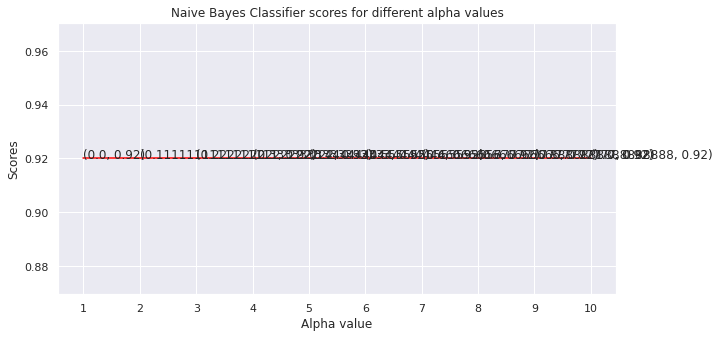

In [0]:
#NB Classifier scores using all variables
from sklearn.naive_bayes import MultinomialNB

K = np.linspace(0,1,10)

nb_scores = []
for k in K:
    nb_clf = MultinomialNB(alpha = k)
    nb_scores.append(round(np.mean(cross_val_score(nb_clf,X_train,y_train,cv=10)),2))

plt.figure(figsize=(10,5))
plt.plot([k for k in range(1,len(K)+1)], nb_scores, color = 'red')
for i in range(1,len(K)+1):
    plt.text(i, nb_scores[i-1], (K[i-1], nb_scores[i-1]))
plt.xticks([i for i in range(1,len(K)+1)])
plt.xlabel('Alpha value')
plt.ylabel('Scores')
plt.title('Naive Bayes Classifier scores for different alpha values')

In [0]:
#Best parameters
nb_clf = MultinomialNB(alpha = 2)
nb_clf.fit(X_train, y_train)

#Test Results 
print_score(nb_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(nb_clf, X_test, y_test)

Test results:

Accuracy Score: 0.9122

Balanced Accuracy Score: 0.7153

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       1.00      1.00      1.00       900
    Russian honey bee       0.55      1.00      0.71       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.00      0.00      0.00        11

             accuracy                           0.91      1424
            macro avg       0.76      0.72      0.69      1424
         weighted avg       0.94      0.91      0.90      1424


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0 114   0   0]
 [  0   0 900   0   0   0]
 [  0   0   0 153   0   0]
 [  0   0   0   0  55   0]
 [  0   0   0  11   0   0]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Itali

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression

Text(0.5, 1.0, 'Logistic Regression for different regularization values')

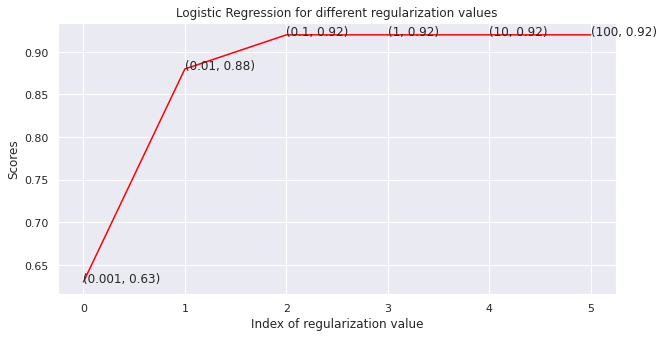

In [0]:
#Logistic Regression scores using all variables

C_param_range = [0.001,0.01,0.1,1,10,100]
log_scores = []
for i in C_param_range:
    log_reg = LogisticRegression(C = i, max_iter=1500)
    log_scores.append(round(np.mean(cross_val_score(log_reg,X_train,y_train,cv=10)),2))

plt.figure(figsize=(10,5))
plt.plot([C_param_range.index(i) for i in C_param_range], log_scores, color = 'red')
for i in C_param_range:
    plt.text(C_param_range.index(i), log_scores[C_param_range.index(i)], (i, log_scores[C_param_range.index(i)]))
plt.xticks([C_param_range.index(i) for i in C_param_range])
plt.xlabel('Index of regularization value')
plt.ylabel('Scores')
plt.title('Logistic Regression for different regularization values')

In [0]:
#Best parameters
log_reg_clf = LogisticRegression(C=1, max_iter=1500)
log_reg_clf.fit(X_train, y_train)

#Test Results 
print_score(log_reg_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(log_reg_clf, X_test, y_test)

Test results:

Accuracy Score: 0.9122

Balanced Accuracy Score: 0.7153

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       1.00      1.00      1.00       900
    Russian honey bee       0.55      1.00      0.71       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.00      0.00      0.00        11

             accuracy                           0.91      1424
            macro avg       0.76      0.72      0.69      1424
         weighted avg       0.94      0.91      0.90      1424


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0 114   0   0]
 [  0   0 900   0   0   0]
 [  0   0   0 153   0   0]
 [  0   0   0   0  55   0]
 [  0   0   0  11   0   0]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Itali

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SMOTE I - sampling_strategy

In [95]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=47)

sampling_strategies= {'Italian honey bee': 2108, 'Carniolan honey bee': 800, 'Russian honey bee': 800,  '1 Mixed local stock 2': 800,
                    'VSH Italian honey bee': 400, 'Western honey bee': 200}

smote=SMOTE(sampling_strategy = sampling_strategies)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

### KNN

Text(0.5, 1.0, 'K Neighbors Classifier scores for different K values')

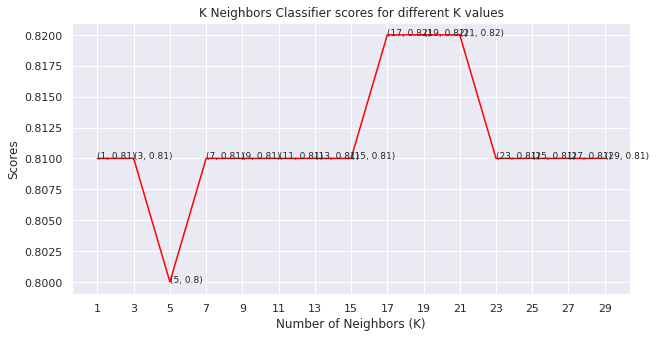

In [71]:
#KNN Classifier scores using all variables

knn_scores = []
K_list=range(1,30,2)
for k in K_list:
    knn_clf = KNeighborsClassifier(n_neighbors = k,metric='jaccard')
    knn_scores.append(round(np.mean(cross_val_score(knn_clf,X_train_sm,y_train_sm,scoring='accuracy',cv=10)),2))

plt.figure(figsize=(10,5))
plt.plot([k for k in K_list], knn_scores, color = 'red')
for i in range(len(K_list)):
    plt.text(K_list[i], knn_scores[i], (K_list[i], knn_scores[i]),fontsize=9)
plt.xticks([i for i in K_list])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')

In [72]:
#Best parameters
knn_clf = KNeighborsClassifier(n_neighbors=17,metric='jaccard')
knn_clf.fit(X_train_sm, y_train_sm)

#Test Results 
print_score(knn_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(knn_clf, X_test, y_test)

Test results:

Accuracy Score: 0.9010

Balanced Accuracy Score: 0.6917

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       0.53      1.00      0.70       161
    Italian honey bee       1.00      1.00      1.00       900
    Russian honey bee       1.00      0.15      0.26       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.00      0.00      0.00        11

             accuracy                           0.90      1424
            macro avg       0.76      0.69      0.66      1424
         weighted avg       0.94      0.90      0.88      1424




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0 161   0   0   0   0]
 [  0   0 900   0   0   0]
 [  0 130   0  23   0   0]
 [  0   0   0   0  55   0]
 [  0  11   0   0   0   0]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  0.8883610451306413
        Italian honey bee  1.0
        Russian honey bee  1.0
    VSH Italian honey bee  1.0
        Western honey bee  1.0

macro avg: 0.9813935075217736
None


One-vs-One ROC AUC scores:
0.928021 (macro),
0.968396 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.972059 (macro),
0.990375 (weighted by prevalence)


### SVM

In [96]:

parameters = {'C': [0.001,0.01,0.1,1,10,100], 'kernel' : ['linear']}

svm_clf = svm.SVC()
svm_cv = GridSearchCV(estimator=svm_clf, param_grid=parameters, scoring='accuracy', cv=5, n_jobs=-1)
svm_cv.fit(X_train_sm, y_train_sm)
print('Best parameters set found:',svm_cv.best_params_)
print('Score with best parameters:',svm_cv.best_score_)



Best parameters set found: {'C': 0.1, 'kernel': 'linear'}
Score with best parameters: 0.8612005037078493


In [97]:
#Best parameters
svm_clf = svm.SVC(C=0.1, kernel='linear', probability=True)
svm_clf.fit(X_train_sm, y_train_sm)

#Test Results 
print_score(svm_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(svm_clf, X_test, y_test)

Test results:

Accuracy Score: 0.9122

Balanced Accuracy Score: 0.7153

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       1.00      1.00      1.00       900
    Russian honey bee       0.55      1.00      0.71       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.00      0.00      0.00        11

             accuracy                           0.91      1424
            macro avg       0.76      0.72      0.69      1424
         weighted avg       0.94      0.91      0.90      1424




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0 114   0   0]
 [  0   0 900   0   0   0]
 [  0   0   0 153   0   0]
 [  0   0   0   0  55   0]
 [  0   0   0  11   0   0]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Italian honey bee  1.0
        Russian honey bee  0.9016522423288749
    VSH Italian honey bee  1.0
        Western honey bee  1.0

macro avg: 0.9836087070548124
None


One-vs-One ROC AUC scores:
0.918290 (macro),
0.964869 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.966515 (macro),
0.990118 (weighted by prevalence)


### Random Forest

In [103]:
#Random Forest Classifier scores using all variables

max_depths = np.linspace(1, 20, 20, endpoint=True)
parameters = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200], 
              'max_depth' : max_depths}

rforest_clf = RandomForestClassifier(n_jobs=-1,class_weight='balanced')
rforest_cv = GridSearchCV(estimator=rforest_clf, param_grid=parameters, scoring='accuracy', cv=5, n_jobs=-1)
rforest_cv.fit(X_train_sm, y_train_sm)
print('Best parameters set found:',rforest_cv.best_params_)
print('Score with best parameters:',rforest_cv.best_score_)


KeyboardInterrupt: ignored

In [0]:
#Best parameters
rndf_clf = RandomForestClassifier(n_estimators = 1, max_depth = 7, class_weight='balanced')
rndf_clf.fit(X_train_sm, y_train_sm)

#Test Results 
print_score(rndf_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(rndf_clf, X_test, y_test)

### Naive Bayes

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/nai

Text(0.5, 1.0, 'Naive Bayes Classifier scores for different alpha values')

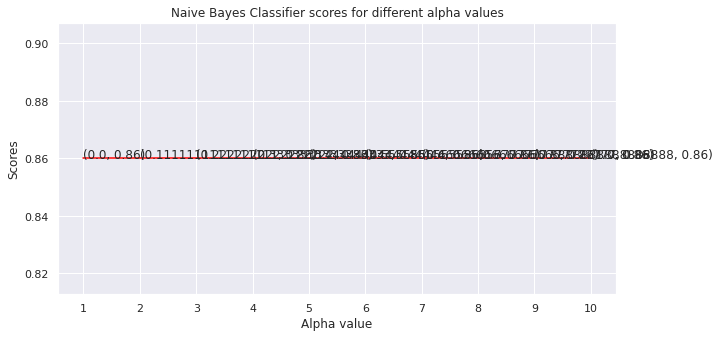

In [104]:
#NB Classifier scores using all variables
from sklearn.naive_bayes import MultinomialNB

K = np.linspace(0,1,10)

nb_scores = []
for k in K:
    nb_clf = MultinomialNB(alpha = k)
    nb_scores.append(round(np.mean(cross_val_score(nb_clf,X_train_sm,y_train_sm,cv=10)),2))

plt.figure(figsize=(10,5))
plt.plot([k for k in range(1,len(K)+1)], nb_scores, color = 'red')
for i in range(1,len(K)+1):
    plt.text(i, nb_scores[i-1], (K[i-1], nb_scores[i-1]))
plt.xticks([i for i in range(1,len(K)+1)])
plt.xlabel('Alpha value')
plt.ylabel('Scores')
plt.title('Naive Bayes Classifier scores for different alpha values')

In [105]:
#Best parameters
nb_clf = MultinomialNB(alpha = 2)
nb_clf.fit(X_train_sm, y_train_sm)

#Test Results 
print_score(nb_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(nb_clf, X_test, y_test)

Test results:

Accuracy Score: 0.9122

Balanced Accuracy Score: 0.7153

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       1.00      1.00      1.00       900
    Russian honey bee       0.55      1.00      0.71       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.00      0.00      0.00        11

             accuracy                           0.91      1424
            macro avg       0.76      0.72      0.69      1424
         weighted avg       0.94      0.91      0.90      1424


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0 114   0   0]
 [  0   0 900   0   0   0]
 [  0   0   0 153   0   0]
 [  0   0   0   0  55   0]
 [  0   0   0  11   0   0]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Itali

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistic Regression

Text(0.5, 1.0, 'Logistic Regression for different regularization values')

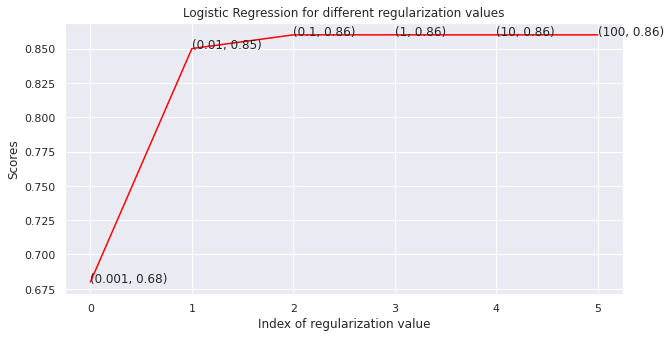

In [106]:
#Logistic Regression scores using all variables

C_param_range = [0.001,0.01,0.1,1,10,100]
log_scores = []
for i in C_param_range:
    log_reg = LogisticRegression(C = i, max_iter=1500)
    log_scores.append(round(np.mean(cross_val_score(log_reg,X_train_sm,y_train_sm,cv=10)),2))

plt.figure(figsize=(10,5))
plt.plot([C_param_range.index(i) for i in C_param_range], log_scores, color = 'red')
for i in C_param_range:
    plt.text(C_param_range.index(i), log_scores[C_param_range.index(i)], (i, log_scores[C_param_range.index(i)]))
plt.xticks([C_param_range.index(i) for i in C_param_range])
plt.xlabel('Index of regularization value')
plt.ylabel('Scores')
plt.title('Logistic Regression for different regularization values')

In [107]:
#Best parameters
log_reg_clf = LogisticRegression(C=1, max_iter=1500)
log_reg_clf.fit(X_train_sm, y_train_sm)

#Test Results 
print_score(log_reg_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(log_reg_clf, X_test, y_test)

Test results:

Accuracy Score: 0.9122

Balanced Accuracy Score: 0.7153

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       1.00      1.00      1.00       900
    Russian honey bee       0.55      1.00      0.71       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.00      0.00      0.00        11

             accuracy                           0.91      1424
            macro avg       0.76      0.72      0.69      1424
         weighted avg       0.94      0.91      0.90      1424


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0 114   0   0]
 [  0   0 900   0   0   0]
 [  0   0   0 153   0   0]
 [  0   0   0   0  55   0]
 [  0   0   0  11   0   0]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Itali

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SMOTE II - balanced

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=47)

smote=SMOTE(sampling_strategy = 'not majority')
X_train_sm2, y_train_sm2 = smote.fit_resample(X_train,y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

### KNN

Text(0.5, 1.0, 'K Neighbors Classifier scores for different K values')

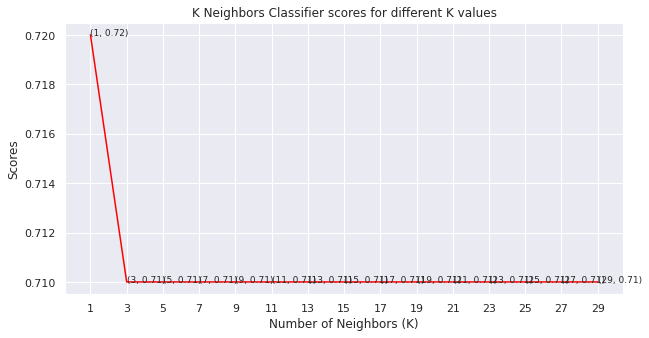

In [77]:
#KNN Classifier scores using all variables

knn_scores = []
K_list=range(1,30,2)
for k in K_list:
    knn_clf = KNeighborsClassifier(n_neighbors = k,metric='jaccard')
    knn_scores.append(round(np.mean(cross_val_score(knn_clf,X_train_sm2,y_train_sm2,scoring='accuracy',cv=10)),2))

plt.figure(figsize=(10,5))
plt.plot([k for k in K_list], knn_scores, color = 'red')
for i in range(len(K_list)):
    plt.text(K_list[i], knn_scores[i], (K_list[i], knn_scores[i]),fontsize=9)
plt.xticks([i for i in K_list])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')

In [78]:
#Best parameters
knn_clf = KNeighborsClassifier(n_neighbors=1,metric='jaccard')
knn_clf.fit(X_train_sm2, y_train_sm2)

#Test Results 
print_score(knn_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(knn_clf, X_test, y_test)

Test results:

Accuracy Score: 0.9122

Balanced Accuracy Score: 0.7153



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       1.00      1.00      1.00       900
    Russian honey bee       0.55      1.00      0.71       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.00      0.00      0.00        11

             accuracy                           0.91      1424
            macro avg       0.76      0.72      0.69      1424
         weighted avg       0.94      0.91      0.90      1424


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0 114   0   0]
 [  0   0 900   0   0   0]
 [  0   0   0 153   0   0]
 [  0   0   0   0  55   0]
 [  0   0   0  11   0   0]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Italian honey bee  1.0
        Russian honey bee  0.9016522423288749
    VSH 

### SVM

In [84]:
parameters = {'C': [0.001,0.01,0.1,1,10,100], 'kernel' : ['linear']}

svm_clf = svm.SVC()
svm_cv = GridSearchCV(estimator=svm_clf, param_grid=parameters, scoring='accuracy', cv=5, n_jobs=-1)
svm_cv.fit(X_train_sm2, y_train_sm2)
print('Best parameters set found:',svm_cv.best_params_)
print('Score with best parameters:',svm_cv.best_score_)



Best parameters set found: {'C': 0.01, 'kernel': 'linear'}
Score with best parameters: 0.7541112814669987


In [88]:
#Best parameters
svm_clf = svm.SVC(C=0.01, kernel='linear', probability=True)
svm_clf.fit(X_train_sm2, y_train_sm2)

#Test Results 
print_score(svm_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(svm_clf, X_test, y_test)

Test results:

Accuracy Score: 0.8287

Balanced Accuracy Score: 0.7404

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       1.00      1.00      1.00       900
    Russian honey bee       1.00      0.15      0.26       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.04      1.00      0.08        11

             accuracy                           0.83      1424
            macro avg       0.84      0.74      0.63      1424
         weighted avg       0.99      0.83      0.85      1424


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0   0   0 114]
 [  0   0 900   0   0   0]
 [  0   0   0  23   0 130]
 [  0   0   0   0  55   0]
 [  0   0   0   0   0  11]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Itali

### Random Forest

In [91]:
#Random Forest Classifier

n_est = [1, 2, 4, 8, 16, 32, 64, 100, 200]
max_depths = np.linspace(1, 7, 7, endpoint=True)

parameters = {'n_estimators': n_est, 'max_depth' : max_depths}

rndf_clf = RandomForestClassifier(n_jobs=-1)
rndf_cv = GridSearchCV(estimator=rndf_clf, param_grid=parameters, scoring='accuracy', cv=5, n_jobs=-1)
rndf_cv.fit(X_train_sm2, y_train_sm2)
print('Best parameters set found:',rndf_cv.best_params_)
print('Score with best parameters:',rndf_cv.best_score_)

Best parameters set found: {'max_depth': 4.0, 'n_estimators': 32}
Score with best parameters: 0.7547439425978804


In [92]:
#Best parameters
rndf_clf = RandomForestClassifier(n_estimators = 32, max_depth = 4,  class_weight = 'balanced')
rndf_clf.fit(X_train_sm2, y_train_sm2)

#Test Results 
print_score(rndf_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(rndf_clf, X_test, y_test)

Test results:

Accuracy Score: 0.8287

Balanced Accuracy Score: 0.7404

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       1.00      1.00      1.00       900
    Russian honey bee       1.00      0.15      0.26       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.04      1.00      0.08        11

             accuracy                           0.83      1424
            macro avg       0.84      0.74      0.63      1424
         weighted avg       0.99      0.83      0.85      1424


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0   0   0 114]
 [  0   0 900   0   0   0]
 [  0   0   0  23   0 130]
 [  0   0   0   0  55   0]
 [  0   0   0   0   0  11]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Itali

### Naive Bayes

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/nai

Text(0.5, 1.0, 'Naive Bayes Classifier scores for different alpha values')

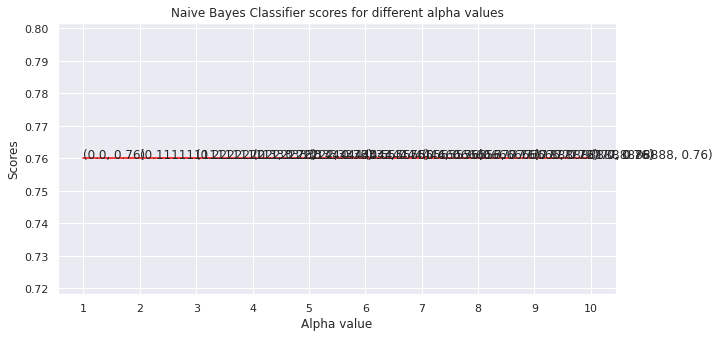

In [0]:
#NB Classifier scores using all variables
K = np.linspace(0,1,10)

nb_scores = []
for k in K:
    nb_clf = MultinomialNB(alpha = k)
    nb_scores.append(round(np.mean(cross_val_score(nb_clf,X_train_sm2,y_train_sm2,cv=10)),2))

plt.figure(figsize=(10,5))
plt.plot([k for k in range(1,len(K)+1)], nb_scores, color = 'red')
for i in range(1,len(K)+1):
    plt.text(i, nb_scores[i-1], (K[i-1], nb_scores[i-1]))
plt.xticks([i for i in range(1,len(K)+1)])
plt.xlabel('Alpha value')
plt.ylabel('Scores')
plt.title('Naive Bayes Classifier scores for different alpha values')

In [0]:
#Best parameters
nb_clf = MultinomialNB(alpha = 2)
nb_clf.fit(X_train_sm2, y_train_sm2)

#Test Results 
print_score(nb_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(nb_clf, X_test, y_test)

Test results:

Accuracy Score: 0.8287

Balanced Accuracy Score: 0.7404

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       1.00      1.00      1.00       900
    Russian honey bee       1.00      0.15      0.26       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.04      1.00      0.08        11

             accuracy                           0.83      1424
            macro avg       0.84      0.74      0.63      1424
         weighted avg       0.99      0.83      0.85      1424


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0   0   0 114]
 [  0   0 900   0   0   0]
 [  0   0   0  23   0 130]
 [  0   0   0   0  55   0]
 [  0   0   0   0   0  11]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Itali

### Logistic Regression

Text(0.5, 1.0, 'Logistic Regression for different regularization values')

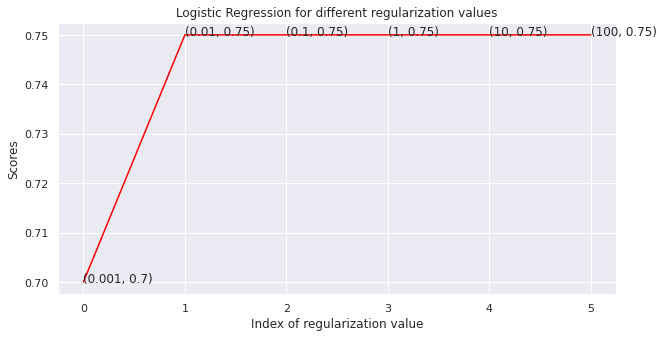

In [93]:
#Logistic Regression scores using all variables

C_param_range = [0.001,0.01,0.1,1,10,100]
log_scores = []
for i in C_param_range:
    log_reg = LogisticRegression(C = i, max_iter=1500)
    log_scores.append(round(np.mean(cross_val_score(log_reg,X_train_sm2,y_train_sm2,cv=10)),2))

plt.figure(figsize=(10,5))
plt.plot([C_param_range.index(i) for i in C_param_range], log_scores, color = 'red')
for i in C_param_range:
    plt.text(C_param_range.index(i), log_scores[C_param_range.index(i)], (i, log_scores[C_param_range.index(i)]))
plt.xticks([C_param_range.index(i) for i in C_param_range])
plt.xlabel('Index of regularization value')
plt.ylabel('Scores')
plt.title('Logistic Regression for different regularization values')

In [94]:
#Best parameters
log_reg_clf = LogisticRegression(C=1, max_iter=1500)
log_reg_clf.fit(X_train_sm2, y_train_sm2)

#Test Results 
print_score(log_reg_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(log_reg_clf, X_test, y_test)

Test results:

Accuracy Score: 0.8287

Balanced Accuracy Score: 0.7404

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       1.00      1.00      1.00       900
    Russian honey bee       1.00      0.15      0.26       153
VSH Italian honey bee       1.00      1.00      1.00        55
    Western honey bee       0.04      1.00      0.08        11

             accuracy                           0.83      1424
            macro avg       0.84      0.74      0.63      1424
         weighted avg       0.99      0.83      0.85      1424


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0   0   0 114]
 [  0   0 900   0   0   0]
 [  0   0   0  23   0 130]
 [  0   0   0   0  55   0]
 [  0   0   0   0   0  11]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Itali

## Feature Selection

In [123]:
importances = mutual_info_classif(X,y)
feature_names = list(X.columns)
print("Important Features: \n")
important_features=[]
for i in range(len(importances)):
  if importances[i]>=0.1:
    important_features.append(feature_names[i])
print("\n".join(important_features))

Important Features: 

address_Athens, GA, USA 30607
address_Des Moines, IA, USA 50315
address_New Orleans, LA, USA 70115
address_Saratoga, CA, USA 95070
health_Varroa, Small Hive Beetles
health_healthy
Day Time_Morning
Day Time_Afternoon


In [0]:
X_new = X[important_features]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.30, random_state=47)

In [131]:
#Best parameters
nb_clf = MultinomialNB(alpha = 2)
nb_clf.fit(X_train, y_train)

#Test Results 
print_score(nb_clf, X_test, y_test)
print("\n")

#AUC
calculate_auc(nb_clf, X_test, y_test)

Test results:

Accuracy Score: 0.8813

Balanced Accuracy Score: 0.6554

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       0.95      1.00      0.97       144
  Carniolan honey bee       1.00      0.27      0.43       161
    Italian honey bee       0.96      0.99      0.98       900
    Russian honey bee       0.50      0.85      0.63       153
VSH Italian honey bee       1.00      0.82      0.90        55
    Western honey bee       0.00      0.00      0.00        11

             accuracy                           0.88      1424
            macro avg       0.74      0.66      0.65      1424
         weighted avg       0.91      0.88      0.87      1424


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  44   0 117   0   0]
 [  8   0 892   0   0   0]
 [  0   0  23 130   0   0]
 [  0   0  10   0  45   0]
 [  0   0   0  11   0   0]]

Specificity:

    1 Mixed local stock 2  0.99375
      Carniolan honey bee  1.0
        I

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test results:

Accuracy Score: 0.9052

Balanced Accuracy Score: 0.6850

Classification Report:
                       precision    recall  f1-score   support

1 Mixed local stock 2       1.00      1.00      1.00       144
  Carniolan honey bee       1.00      0.29      0.45       161
    Italian honey bee       0.99      1.00      0.99       900
    Russian honey bee       0.55      1.00      0.71       153
VSH Italian honey bee       1.00      0.82      0.90        55
    Western honey bee       0.00      0.00      0.00        11

             accuracy                           0.91      1424
            macro avg       0.76      0.69      0.68      1424
         weighted avg       0.94      0.91      0.89      1424


Confusion Matrix:
[[144   0   0   0   0   0]
 [  0  47   0 114   0   0]
 [  0   0 900   0   0   0]
 [  0   0   0 153   0   0]
 [  0   0  10   0  45   0]
 [  0   0   0  11   0   0]]

Specificity:

    1 Mixed local stock 2  1.0
      Carniolan honey bee  1.0
        Itali

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
